# Visualize cell tracks on top of gridded data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from functools import partial
import ipywidgets

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid

In [3]:
from tobac.themes import tint # For convenience in loading multiple radar grids
import pyart # To get colormaps


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [4]:
nc_file_path = ('../test/*grid.nc')
nc_grid = tint.io.load_cfradial_grids(nc_file_path)
tracks = xr.open_dataset('../test/track_20170713070208_20170713075719.nc')

/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [5]:
class TrackSummary(object):
    def __init__(self, grid_ds, tracks_ds):
        """ Convenience API for pulling data out of a TOBAC/TINT tracks object """
        
        # Should push this change upstream into TOBAC/TINT
        self.grid_ds = grid_ds
        self.tracks_ds = tracks_ds.drop('cell_id').assign_coords(cell=tracks_ds['cell'].astype('uint64'))
        track_table = self.tracks_ds.drop_dims([d for d in self.tracks_ds.dims if d != 'cell'])
        self.track_groups = track_table.groupby('cell')
#         self.most_freq = self.track_groups.size().sort_values(ascending=False).index
#         most_freq would be found by sorting cell_scan_count
        cell_ids = {cid:len(v) for cid, v in self.track_groups.groups.items()}
        id_data = np.fromiter(cell_ids.keys(), dtype=int)
        count_data = np.fromiter(cell_ids.values(), dtype=int)
        cell_scan_count = xr.DataArray(count_data, coords={'cell':id_data}, dims=tracks_ds.cell_id.dims, name='cell_scan_count')
        self.all_times = np.sort(np.unique(self.tracks_ds.cell_time))
        
        # Calculate some stats
        # min of always, sometimes, never isolated
        # min(True, True, True) = True
        # min(True, False, True) = False
        # min(False, False, False) = False
        # max of always, sometimes, never isolated
        # max(True, True, True) = True
        # max(True, False, True) = True
        # max(False, False, False) = False        
        
        # Assume proj is aeqd, the default for PyART.
        cs_attrs = self.grid_ds['ProjectionCoordinateSystem'][0].attrs
#         {'latitude_of_projection_origin': 29.471900939941406,
#          'longitude_of_projection_origin': -95.0787353515625,
#          '_CoordinateTransformType': 'Projection',
#          '_CoordinateAxes': 'x y z time',
#          '_CoordinateAxesTypes': 'GeoX GeoY Height Time',
#          'grid_mapping_name': 'azimuthal_equidistant',
#          'semi_major_axis': 6370997.0,
#          'inverse_flattening': 298.25,
#          'longitude_of_prime_meridian': 0.0,
#          'false_easting': 0.0,
#          'false_northing': 0.0}
        if cs_attrs['grid_mapping_name'] == 'azimuthal_equidistant':
            self.grid_proj = ccrs.AzimuthalEquidistant(central_latitude=cs_attrs['latitude_of_projection_origin'],
                                                       central_longitude=cs_attrs['longitude_of_projection_origin'],
                                                       false_easting=cs_attrs['false_easting'],
                                                       false_northing=cs_attrs['false_northing'],)
        
        column_names = list(track_table.variables.keys())
        column_names.remove('cell')
        column_names.remove('cell_id')
        track_mins = self.track_groups.min().rename({n:n+'_min' for n in column_names})
        track_maxs = self.track_groups.max().rename({n:n+'_max' for n in column_names})
                
        track_stats = xr.merge([track_mins, track_maxs])
        track_stats['scan_count'] = cell_scan_count
        
        sum_vars = ['isolated'] 
        sum_ds = track_table.drop([c for c in column_names if c not in sum_vars])
        track_sums = sum_ds.groupby('cell').sum()
        track_stats['isolated_count'] = track_sums.isolated
        track_stats['isolated_fraction'] = track_stats['isolated_count']/track_stats['scan_count']
        self.track_stats = track_stats
                
    def active_track_ids(self, time):
        t = pd.Timestamp(time)
        in_range = ((t >= self.track_stats['cell_time_min']) & 
                    (t < self.track_stats['cell_time_max'])
                   )
        return self.track_stats.cell[{'cell':in_range}]
    
    def active_grid(self, time, field):
        t = time
        if field == 'cell_mask':
            return self.tracks_ds[field].sel({'time':t}, method='nearest')
        else:
            return self.grid_ds[field].sel({'time':t}, method='nearest')
                
    def active_track_stats(self, time):
        """ Get the stats dataframe for active tracks at time"""
        uids = self.active_track_ids(time)
        return self.track_stats.loc[{'cell':uids}]
    
    def widget(self, figure=None, isolated_increment=0.05):
        from ipywidgets import interact, widgets, fixed
        from functools import partial
        time_selection_mapping = {v:i for i, v in enumerate(self.all_times)}
        slider_layout = widgets.Layout(width='50%')
        time_slider = widgets.SelectionSlider(options=time_selection_mapping, 
                                              layout=slider_layout, description='Time')
        isolated_min_slider = widgets.FloatSlider(min=0.0, max=1.0, step=isolated_increment, 
                                                  layout=slider_layout, description="Isolation")
        show_tracks = widgets.Checkbox(value=True, description='Tracks')

        return partial(interact,
                       time=time_slider,
                       isolated_min=isolated_min_slider,
                       show_tracks = show_tracks,
#                        figure = fixed(figure)
                      )

/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:

hou_ctr_lat, hou_ctr_lon = 29.4719, -95.0792

def plot(time, isolated_min, show_tracks, figure=None):
    # Get the data
    t = summary.all_times[time] # convert slider index to time
    stats = summary.active_track_stats(t)
    isolated_enough = (stats['isolated_fraction'] >= isolated_min)
    isolated_track_ids = stats[{'cell':isolated_enough}].cell
    
    all_cell_ids = np.unique(summary.track_stats.cell)
    cell_min_id = all_cell_ids.min()
    cell_max_id = all_cell_ids.max()
        
    # Plot
    fig.clear()
    latlon_proj = ccrs.PlateCarree()
    projection=summary.grid_proj
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    axs = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.4,
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.4,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode
    for ax in axs:
        ax.coastlines()
        ax.set_extent((hou_ctr_lon-1.0, hou_ctr_lon+1.0,
                       hou_ctr_lat-1.0, hou_ctr_lat+1.0))
    
    
    # Gridded background
    grid_extent = (summary.grid_ds.x.min(), summary.grid_ds.x.max(),
                   summary.grid_ds.y.min(), summary.grid_ds.y.max())

    
    # Cell ID
    cell_id = summary.active_grid(t, 'cell_mask')
    cell_id = cell_id.where(cell_id!=0, np.nan)
    im = axs[0].imshow(cell_id, vmin=0, vmax=cell_max_id, cmap='prism',
                  transform=summary.grid_proj, extent=grid_extent, origin='lower')
    axs[0].set_title('Cell ID')
    axs.cbar_axes[0].colorbar(im)

    # Column max reflectivity
    refl = summary.active_grid(t, 'reflectivity').max(axis=0)
#     data = nc_grid.reflectivity[{'time':t}].max(axis=0).where(data!=0, np.nan) # Column max 
    im = axs[1].imshow(refl, vmin=-24, vmax=72, cmap='pyart_LangRainbow12',
                  transform=summary.grid_proj, extent=grid_extent, origin='lower')
    axs[1].set_title('Reflectivity (dBZ)')
    axs.cbar_axes[1].colorbar(im)
    
    # Column max Zdr
    refl = summary.active_grid(t, 'differential_reflectivity').max(axis=0)
#     data = nc_grid.reflectivity[{'time':t}].max(axis=0).where(data!=0, np.nan) # Column max 
    im = axs[2].imshow(refl, vmin=-2, vmax=6, cmap='pyart_LangRainbow12',
                  transform=summary.grid_proj, extent=grid_extent, origin='lower')
    axs[2].set_title('Differential Reflectivity (dB)')
    axs.cbar_axes[2].colorbar(im)
    
    # Column max Kdp
    refl = summary.active_grid(t, 'KDP_CSU').max(axis=0)
#     data = nc_grid.reflectivity[{'time':t}].max(axis=0).where(data!=0, np.nan) # Column max 
    im = axs[3].imshow(refl, vmin=-2, vmax=3, cmap='pyart_LangRainbow12',
                  transform=summary.grid_proj, extent=grid_extent, origin='lower')
    axs[3].set_title('Specific Differential Phase (deg/km)')
    axs.cbar_axes[3].colorbar(im)

    
    have_data = False
    if show_tracks == True:
        for tid in isolated_track_ids:
            # loop over dataframes for each cell
            track = summary.track_groups[int(tid)]
            t_stat = stats.loc[{'cell':tid}]        
            time_offsets = track['cell_time'] - t
            cell_idx = int(abs(time_offsets).data.argmin())
            cell_now = track[{'cell':cell_idx}]

            for axi in range(len(axs)):
                axs[axi].plot(track['cell_ctr_lon'], track['cell_ctr_lat'], transform=latlon_proj,
                              color='black', alpha=0.5, linewidth=1.0)

                cell_lon, cell_lat = cell_now['cell_ctr_lon'], cell_now['cell_ctr_lat']
                last_scatter = axs[axi].scatter(cell_lon, cell_lat, c=[float(tid)], s=9, marker='s', cmap='prism', 
                               vmin=cell_min_id, vmax=cell_max_id, transform=latlon_proj)
                # work around text not being clipped properly by matplotlib (known issue)
        #         transformed_center = axs[0].background_patch.get_transform().transform((cell_lon, cell_lat))
        #         print(transformed_center)
        #         print(axs[0].bbox)
        #         if axs[0].background_patch.contains_point(transformed_center):
                txt_art = axs[axi].text(cell_now['cell_ctr_lon'], cell_now['cell_ctr_lat'], int(tid), transform=latlon_proj,
                                       fontsize=9)
            have_data = True
    return fig
#     if have_data:
#         axs.cbar_axes[0].colorbar(last_scatter) #only need last scatter since they all have the same cmap

/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipywidgets/widgets/widget_selection.py:121: DeprecationWarning: Support for mapping types has been deprecated and will be dropped in a future release.
  warnings.warn("Support for mapping types has been deprecated and will be dropped in a future release.", DeprecationWarning)
/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipywidgets/widgets/widget_selection.py:121: DeprecationWarning: Support for mapping types has been deprecated and will be dropped in a future release.
  warnings.warn("Support for mapping types has 

interactive(children=(SelectionSlider(description='Time', layout=Layout(width='50%'), options={numpy.datetime6…

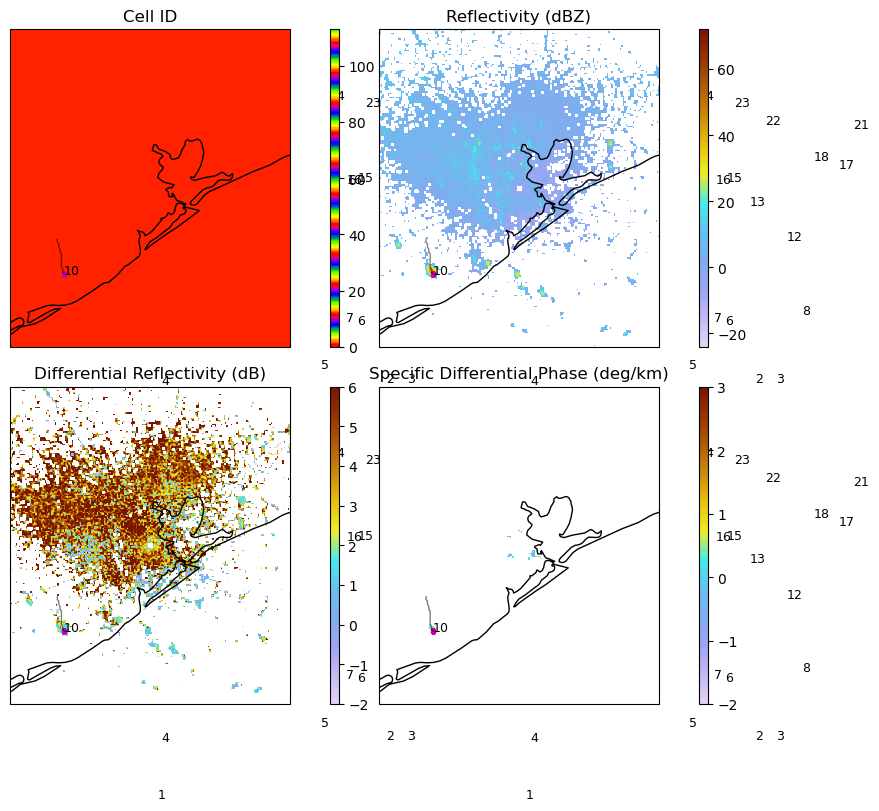

In [9]:

summary = TrackSummary(nc_grid,tracks)

plt.close('all')
fig = plt.figure(figsize=(9,9))

@summary.widget(figure=fig)
def do_plot(*args, **kwargs):
    plot(*args, **kwargs)
fig

In [41]:
tracks

/Users/ebruning/miniconda3/envs/tobac-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:               (cell: 512, time: 18, x: 501, y: 501, z: 31)
Coordinates:
  * y                     (y) float64 -2.5e+05 -2.49e+05 ... 2.49e+05 2.5e+05
  * x                     (x) float64 -2.5e+05 -2.49e+05 ... 2.49e+05 2.5e+05
  * time                  (time) datetime64[ns] 2017-07-13T07:02:08 ... 2017-...
  * cell                  (cell) object '0' '1' '2' '3' ... '69' '97' '113'
    cell_id               (cell) object '0' '1' '2' '3' ... '69' '97' '113'
  * z                     (z) float64 0.0 500.0 1e+03 ... 1.45e+04 1.5e+04
Data variables:
    grid_x                (cell) float64 379.5 254.5 415.7 ... 399.5 384.9 27.12
    grid_y                (cell) float64 52.44 75.65 115.8 ... 279.0 300.1 497.8
    cell_ctr_lon          (cell) float64 -93.76 -95.03 -93.4 ... -93.71 -97.33
    cell_ctr_lat          (cell) float64 27.67 27.88 28.24 ... 29.71 29.9 31.68
    area                  (cell) float64 16.0 26.0 11.0 31.0 ... 24.0 16.0 8.0
    vol                   (cell) float64 44.5 61.5 19.0 103.0 ... 83.0 40.5 7.5
    max                   (cell) float64 nan nan nan nan nan ... nan nan nan nan
    max_alt               (cell) float64 7.5 5.0 6.0 7.0 ... 5.5 6.5 6.0 12.5
    isolated              (cell) bool True True True True ... False True True
    cell_time             (cell) datetime64[ns] 2017-07-13T07:02:08 ... 2017-...
    cell_mask             (time, y, x) float64 ...
    cell_parent_storm_id  (cell) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    cf_tree_order:  storm_id cell_id
    tree_id:        2327